# Adding interpretability

The basic idea behind LIME and the general concept of bringing 'interpretability' to complex models is the following: train a model with the input features of the complex model, and learn the response given by the complex model to later explain what's the effect of each individual feature on the response.

The problem is that this approach is too simplistic and does not necessarily produces the right explanation to the phenomena learned by the complex model. In fact, any potential interaction between variables is not considered. Therefore, these ideas must be used with care.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adding-interpretability" data-toc-modified-id="Adding-interpretability-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adding interpretability</a></span><ul class="toc-item"><li><span><a href="#Data-initialization" data-toc-modified-id="Data-initialization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data initialization</a></span></li><li><span><a href="#Boosting-tree" data-toc-modified-id="Boosting-tree-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Boosting tree</a></span></li><li><span><a href="#Adding-interpretability" data-toc-modified-id="Adding-interpretability-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Adding interpretability</a></span></li><li><span><a href="#Interpretability,-through-simple-surrogate-models" data-toc-modified-id="Interpretability,-through-simple-surrogate-models-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Interpretability, through simple surrogate models</a></span></li></ul></li></ul></div>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import graphviz
import warnings

from IPython.display import Image
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.validation import column_or_1d

from lime.lime_tabular import LimeTabularExplainer

from dataset import Dataset
%matplotlib inline

## Data initialization

In [28]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.set_target('Channel')
X, Y = wholesale.split()
wholesale.summary()

Features Summary (all):
'Region'          : float64    Min.(1.0) 1stQ(2.0) Med.(3.0) Mean(2.54) 3rdQ(3.0) Max.(3.0)
'Fresh'           : float64    Min.(3.0) 1stQ(3127) Med.(8504) Mean(1200) 3rdQ(1693) Max.(1121)
'Milk'            : float64    Min.(55.0) 1stQ(1533) Med.(3627) Mean(5796) 3rdQ(7190) Max.(7349)
'Grocery'         : float64    Min.(3.0) 1stQ(2153) Med.(4755) Mean(7951) 3rdQ(1065) Max.(9278)
'Frozen'          : float64    Min.(25.0) 1stQ(742.) Med.(1526) Mean(3071) 3rdQ(3554) Max.(6086)
'Detergents_Paper': float64    Min.(3.0) 1stQ(256.) Med.(816.) Mean(2881) 3rdQ(3922) Max.(4082)
'Delicassen'      : float64    Min.(3.0) 1stQ(408.) Med.(965.) Mean(1524) 3rdQ(1820) Max.(4794)
'Channel'         : float64    Min.(1.0) 1stQ(1.0) Med.(1.0) Mean(1.32) 3rdQ(2.0) Max.(2.0)


## Boosting tree

One of the most important phases in trees is deciding on what is the best combination of parameters that control the optimal values for

- depth of the tree, 
- min number of samples per leaf,
- min number of samples to perform a split,
- max number of features to consider when looking for the best split,
- ...

All these parameters control the growth of the tree, and given the lack of other pruning mechanisms, this is the best way of considering that your tree model gets "**pruned**" to avoid overfitting.

How to perform gridsearch or hyper parameter tuning over Gradient Boosting trees?


In [29]:
gb = GradientBoostingClassifier(n_estimators=1000, 
                                min_samples_leaf=0.05,
                                min_samples_split=0.05,
                                subsample=0.8,
                                learning_rate=0.01,
                                max_features='log2',
                                max_depth=4, 
                                random_state=0,
                                criterion='friedman_mse')

# Grid search takes 10 or more minutes, so I disable it.
gb.fit(X.train, column_or_1d(Y.train))  

score = gb.score(X.train, column_or_1d(Y.train))
print('Score: {:.4f}'.format(score))

Score: 0.9972


In [30]:
hpgb_scores = cross_val_score(
    gb, 
    X.test, 
    column_or_1d(Y.test))
avg_score = np.median(hpgb_scores)
print('Med. Score: {:.4f}'.format(avg_score))

Med. Score: 0.8824


## Adding interpretability

Let's explore how LIME (Local Interpretable Model-agnostic Explanations) brings interpretability to our previously trained gradient boosting tree with the optimal parameters.

First of all print out the values we want to predict (random pick from the training set):

In [31]:
idx=333
print('Sample being traced\n-------------------------\n', 
      wholesale.data.iloc[idx, :], sep='')

Sample being traced
-------------------------
Region                  2.0
Fresh                8565.0
Milk                 4980.0
Grocery             67298.0
Frozen                131.0
Detergents_Paper    38102.0
Delicassen           1215.0
Name: 333, dtype: float64


This is the way LIME adds interpretability, this time, to a single prediction.

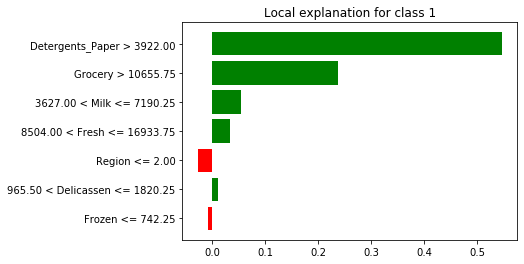

In [32]:
explainer = LimeTabularExplainer(
    wholesale.features.values, 
    mode='classification', 
    feature_names=wholesale.names('features'))

exp = explainer.explain_instance(wholesale.features.iloc[idx, :], 
    optimal_gb.predict_proba)

%matplotlib inline
p = exp.as_pyplot_figure();

## Interpretability, through simple surrogate models

Let's build a dataset with the input features as they're, and the target variable being the output from the gradient boosting model trained before.

In [33]:
input_cols = wholesale.features
predictions = optimal_gb.predict(wholesale.features)
output_col = pd.Series(data=predictions, name='Channel')
predicted_df = pd.concat([input_cols, output_col], axis=1)

ws = Dataset.from_dataframe(predicted_df)
ws.set_target('Channel')

print('Sample being traced\n-----------------------------\n', 
      ws.data.iloc[idx, :], sep='')

Sample being traced
-----------------------------
Region                  2.0
Fresh                8565.0
Milk                 4980.0
Grocery             67298.0
Frozen                131.0
Detergents_Paper    38102.0
Delicassen           1215.0
Name: 333, dtype: float64


Build a simple decision tree with the same input features as the gradient boosting tree, but with its predictions as target variable. The tree is a single tree, but will help us to see if the decision process is similar to that followed by the GB tree.

In [34]:
X, Y = ws.split()
surrogate = DecisionTreeClassifier(
    min_samples_leaf=10,
    min_samples_split=10,
    random_state=0, 
    max_depth=3)
surrogate.fit(X.train, Y.train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

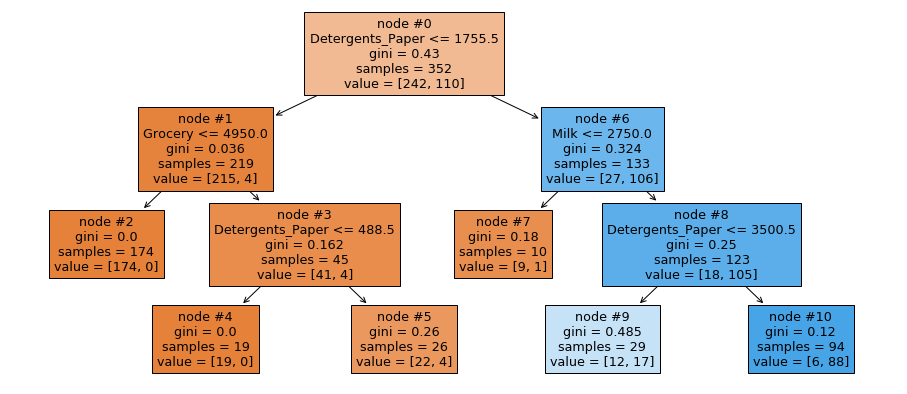

In [35]:
plt.figure(figsize=(16, 7))
tree.plot_tree(surrogate, feature_names=wholesale.feature_names, 
               node_ids=True, filled=True);

Let's reproduce what is the decision path for the entry selected, to see what nodes are shaping the decision in the surrogate model:

In [36]:
print('Index selected: {}'.format(idx))
path = surrogate.decision_path(X=ws.features.iloc[idx, :].values.reshape(1, -1))
print('Decision Path:\n', path, sep='')
prediction = surrogate.predict(
    ws.features.iloc[idx, :].values.reshape(1, -1))
print('Prediction by surrogate model: {}'.format(prediction[0]))
print('Actual response for idx({}): {}'.format(idx, wholesale.target[idx]))

Index selected: 333
Decision Path:
  (0, 0)	1
  (0, 6)	1
  (0, 8)	1
  (0, 10)	1
Prediction by surrogate model: 2.0
Actual response for idx(333): 2.0


When plotting the features importance coming from the surrogate models, we can check that the two most important features that shape the classification decision match those coming from the LIME package: Detergents_paper and Grocery. 

However, this simpler model is not able to add any importance to the rest of the features, probably because of its simplicity and low depth. We can also build an alternate interpretation with surrogate models by fitting a logistic regression and checking the coefficients.

In [37]:
def features_importance(tree, X):
    """
    Plot the variables importance from the fitted tree and the 
    training dataset used.
    """
    importances = tree.feature_importances_
    indices = np.argsort(importances)
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,4))
    plt.title("Feature importances")
    plt.barh(range(X.train.shape[1]), importances[indices],
           color="r", align="center")
    index_names = [list(X.train)[i] for i in indices]
    plt.yticks(range(X.train.shape[1]), index_names)
    plt.ylim([-1, X.train.shape[1]])
    plt.xlim([0.0, 1.0])
    plt.show()

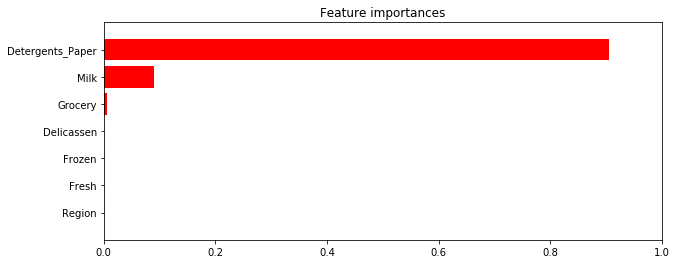

In [38]:
features_importance(surrogate, X)